##준비


In [ ]:
# 폰트 준비
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
# 폰트 색상 준비
R  = '\033[31m' # red 오류 메세지
G  = '\033[32m' # green 결과 보여줄 때 헤더
B  = '\033[34m' # blue 메뉴 색상으로 사용 예정
C  = '\033[36m' # cyan
N  = '\033[0m'  # normal
S  = '\033[1m'  # strong(bold)

In [ ]:
# 다운로드
!pip install pyproj==2.6.1

In [ ]:
# 모듈 준비
import pandas as pd
import math
import numpy as np
from pyproj import Proj, transform
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import openpyxl
import csv

In [ ]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/gdrive')
directory_path = '/content/gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#병원데이터 불러오기
df=pd.read_excel(directory_path+'hospital.xlsx',index_col=0)

In [ ]:
#정상영업중인 병원만 포함
df=df[df['영업상태구분코드']==1]

In [ ]:
#약국데이터 불러오기
df_pharmacy=pd.read_excel(directory_path+'pharmacy.xlsx',index_col=0)
#정상 영업중 약국만 포함
df_pharmacy=df_pharmacy[df_pharmacy['영업상태구분코드']==1]

##시작

In [ ]:
def intro():    # 사용자 기본 정보 입력 함수]
    global df
    global df_pharmacy
    global df_pharmacy1
    global adr1_do   # 전역 변수 설정
    adr1_do = input("\n시/도 입력: ")   # 사용자 입력

    import csv
    f = open(directory_path + 'hospital.csv', 'r', encoding='cp949')
    data = csv.reader(f)
    header = next(data)
 
    do = set()    # 중복 제거용

    for row in data :
        if row[19] != '':    # 비어있지 않음
            do.add(row[19].split()[0])

    while True:    # 오류 입력 실행
        if adr1_do not in do:
            print(R+"입력 오류!"+N+"\n여기에 있는지 확인해보세요")
            do = list(do)
            do.sort()   # 리스트 변환 후 정렬
            print(','.join(do))   # 출력
            intro()   #재실행
            break
        else:
            break
    f.close()

    mask4=df['도로명전체주소'].str.contains(adr1_do,na=False) #입력한 값을 주소로 갖는 데이터만 포함
    df=df[mask4]

    mask5=df_pharmacy['도로명전체주소'].str.contains(adr1_do,na=False) #입력한 값을 주소로 갖는 데이터만 포함
    df_pharmacy1= df_pharmacy[mask5]
    return(df_pharmacy1)

In [ ]:
def menu():
    print()
    print(S+B+"메뉴 1",N+B+ "가까운 병원찾기") #메뉴 정보 출력
    print(S+B+"메뉴 2",N+B+ "병원 비교하기")
    print(S+B+"메뉴 3",N+B+ "현황 체크하기"+N,'\n')

    while True:
        menu_select = input("숫자로 메뉴를 선택해주세요\n(1/2/3을 입력해주세요)\n\n\t대답: ") #메뉴 선택
        if menu_select == '1':
            sub_menu_1() #메뉴 1실행
            break
        elif menu_select == '2':
            sub_menu_2() #메뉴2실행
            n=input("\n병원을 선택해서 비교하시겠습니까?\n-비교하기: Y 입력\n-그만두기: N 입력\n\n\t대답:") #비교 다시 실행할지 묻기
            if n=="Y":
                information()
                break
            elif n=="N":
                break
            else:
                print(R+"입력 오류!"+N)
                continue
        elif menu_select == '3':
                sub_menu_3()  #메뉴3실행
                break
        else:
            print(R+"입력 오류!"+N)
            continue

##가까운병원찾기


In [ ]:
def sub_menu_1():   # 메뉴 1 응급실 고려 여부 함수
    print('\n'+S+B+"메뉴 1",N+B+"가까운병원찾기"+N+'\n')
    emergency_answer = input("\n응급실이 필요합니까?\n-응급실이 필요: Y 입력\n-응급실 불필요: N 입력\n\n\t대답:") #응급실 필요여부 묻기
    while True:
        if emergency_answer == "Y":   # 응급 상황일 때
            emergency_situation() # 응급의학과 포함 함수 실행
            pharmacy()    #근처 약국 출력
            break
        elif emergency_answer == "N": #아닐때
            general_situation_distance() # 응급의학과 고려 안 하는 함수 실행
            pharmacy()     #근처 약국 출력
            break
        else:
            print(R+"입력 오류!"+N)
            emergency_answer = input("Y나 N으로 입력해주세요: ")
            continue

In [ ]:
from pyproj import Transformer
def get_user_location():    # 사용자 위치 입력 함수
  def in_function():
    print("학교, 역, 건물 등으로 입력해주세요.")
    n=input("현재 위치를 입력하세요: ")

    app=Nominatim(user_agent='tutorial') 
    location=app.geocode(n)
    a=location.latitude
    b=location.longitude
    return a,b #사용자위치를 위도 경도 값으로 돌려줌

  while True: #오류나는 경우에 대해서 재실행
    try:
      a,b=in_function()
      break
    except AttributeError:
      print("(오류)다시 시도하세요")
      continue
    except timeout:
      print("(오류)다시 시도하세요")
      continue  
    except GeocoderTimedOut:
      print("(오류)다시 시도하세요")
      continue  
    except NameError:
      print("(오류)다시 시도합니다")
      continue 
    except UnboundLocalError:
      print("(오류)다시 시도합니다")
      continue       
  
  transformer=Transformer.from_crs("EPSG:4326","EPSG:2097",always_xy=True) 
  lat=a
  lon=b
  xx,yy=transformer.transform(lon,lat)
  return xx,yy #사용자 위치의 경도 위도를 x,y 좌표값으로 돌려줌

In [ ]:
def emergency_situation(): # 응급상황일 경우 실행 
  global df
  global hospital_information
  xx,yy=get_user_location() #사용자 위치 변환 좌표 
  min=10000
  df_emergency=df[df['진료과목내용명'].str.contains('응급의학과')] #응급의학과(응급실)포함한 병원만 다루기
  for i in df_emergency.index: #for문을 실행해 제일 거리가 가까운 병원 인덱스 저장
    s=math.sqrt((xx-df.loc[i,'좌표정보(X)'])**2+(yy-df.loc[i,'좌표정보(Y)'])**2)
    if s<min:
      min=s
      index_of_close_hospital=i
  street=df.loc[index_of_close_hospital]['도로명전체주소']
  name=df.loc[index_of_close_hospital]['사업장명']
  number=df.loc[index_of_close_hospital]['소재지전화']
  hospital_information={'이름':name,'주소':street,'번호':number}
  keyList = hospital_information.keys()
  print('\n'+"\U0001F691",B+"가장 가까운 병원 결과","\U0001F691")
  for item in keyList : #병원 정보 출력
    print(G+"%s: %s"%(item,hospital_information[item]))
  print('\n'+"\U0001F48A",B+"근처 약국 결과","\U0001F48A")    


In [ ]:
def general_situation():  # 일반적 상황일때 필요한 데이터 처리
  global df
  prompt="""
1.일반병원
2.종합병원
3.치과병원
4.한방병원
5.요양병원\n"""
  print(prompt)
  hospital_type=int(input("병원 종류를 입력하세요\n(1/2/3/4/5로 입력)\n\t대답: ")) #병원 종류 입력 받기

  while True: #각각 선택된 병원 종류의 이름을 포함한 데이터만 포함
    if hospital_type==1:
      df2=df[df['의료기관종별명']=='병원'] #각각 선택한 옵션을 의료기관종별명에 가진 데이터만 다루기
      subject_type_string=get_medical_subject() #일반병원을 선택하는 경우에 한해 상세 진료과목명 묻기
      mask1=df2['진료과목내용명'].str.contains(subject_type_string,na=False) 
      df2=df2[mask1] 
      break
    elif hospital_type==2:
      df2=df[df['의료기관종별명']=='종합병원']
      break
    elif hospital_type==3:
      df2=df[df['의료기관종별명']=='치과병원']
      break
    elif hospital_type==4:
      df2=df[df['의료기관종별명']=='한방병원']
      break
    elif hospital_type==5:
      df2=df[df['의료기관종별명']=='요양병원(일반요양병원)']
      break
    else:
      print("입력 오류!")
      hospital_type=int(input("메뉴에 있는 숫자로 입력하세요: "))
      continue
  return(df2)

In [ ]:
def general_situation_distance(): #일반적 상황일때 가까운 병원 구하기
  global df
  global hospital_information
  df2=general_situation() #사용자 위치 묻기
  xx,yy=get_user_location() #위치를 x,y 좌표로 반환
  min=10000
  for i in df2.index: #가장 가까운 병원 출력
    s=math.sqrt((xx-df.loc[i,'좌표정보(X)'])**2+(yy-df.loc[i,'좌표정보(Y)'])**2)
    if s<min:
      min=s
      index_of_close_hospital=i
  street=df.loc[index_of_close_hospital]['도로명전체주소']
  name=df.loc[index_of_close_hospital]['사업장명']
  number=df.loc[index_of_close_hospital]['소재지전화']
  hospital_information={'이름':name,'주소':street,'번호':number}
  keyList = hospital_information.keys()
  print('\n'+"\U0001F691",B+"가장 가까운 병원 결과","\U0001F691")
  for item in keyList :#병원 정보 출력
    print(G+"%s: %s"%(item,hospital_information[item]))
  print('\n'+"\U0001F48A",B+"근처 약국 결과","\U0001F48A")    

In [ ]:
def get_medical_subject(): #일반적인 상황에서 진료과목 묻기
  prompt1="""
1.내과
2.피부과
3.소아청소년과
4.이비인후과
5.안과
6.외과
7.재활의학과
8.정형외과
9.신경과
10.흉부외과
11.성형외과
12.산부인과
13.정신건강의학과
14.비뇨의학과
15.그 외 기타"""
  print(prompt1)
  subject_type=int(input("\n진료과목을 입력하세요\n(1부터 15까지의 숫자로 입력)\n\t대답:"))#진료과목명 묻기

  if subject_type==1:#1번 내과 선택할 경우
    subject_type_string="내과" #내과라는 문자로 바꿔서 저장
  elif subject_type==2:
    subject_type_string="피부과"
  elif subject_type==3:
    subject_type_string="소아청소년과"
  elif subject_type==4:
    subject_type_string="이비인후과"
  elif subject_type==5:
    subject_type_string="안과"
  elif subject_type==6:
    subject_type_string="외과"
  elif subject_type==7:
    subject_type_string="재활의학과" 
  elif subject_type==8:
    subject_type_string="정형외과"
  elif subject_type==9:
    subject_type_string="신경과"
  elif subject_type==10:
    subject_type_string="흉부외과"
  elif subject_type==11:
    subject_type_string="성형외과"
  elif subject_type==12:
    subject_type_string="산부인과"
  elif subject_type==13:
    subject_type_string="정신건강의학과"
  elif subject_type==14:
    subject_type_string="비뇨의학과"
  elif subject_type==15:
    while True:
      print("신경외과, 마취통증의학과, 영상의학과, 병리과, 진단검사의학과, 한방재활의학과")
      subject_type_string=input("진료과목을 입력하세요\n(띄어쓰기없이 입력하세요):")
      if subject_type_string in ["신경외과","마취통증의학과","영상의학과","병리과","진단검사의학과","한방재활의학과"]:
        break
      else:
        print("과를 정확히 입력하세요")
        continue
  else:
    print(R+"입력 오류!"+N)
    get_medical_subject() 

  return(subject_type_string) #저장된 문자값(과목명)돌려주기

In [ ]:
def pharmacy():   # 약국 찾는 함수
  global hospital_information
  global df_pharmacy1
  global adr1_do
  new_address=[]
  new_address=hospital_information['주소'].split(' ') #앞서 출력한 한개의 병원 정보중 주소값 이용
  
  mask3=df_pharmacy1['도로명전체주소'].str.contains(new_address[2],na=False) #병원 주소값중 3번째 위치한 단어이용해서 그 단어가 포함된 주소를 가진 약국만 다루기
  df_pharmacy2=df_pharmacy1[mask3]

  pharmacy_information=[]
  for ss in list(df_pharmacy2.index):#약국 정보 저장
    aa=df_pharmacy2.loc[ss]['도로명전체주소']
    bb=df_pharmacy2.loc[ss]['사업장명']
    cc=df_pharmacy2.loc[ss]['소재지전화']
    pharmacy_information.append([aa,bb,cc])

  for i in pharmacy_information:#약국 정보 출력
    print(G+i[1]+N,i[0],i[2])

##병원 비교하기

In [ ]:
def sub_menu_2(): #2번메뉴 실행
  print('\n'+S+B+"메뉴 2",N+B+"비교하기"+N+'\n')
  adr2_si = input("시군구를 입력하세요 \n(예)마포구: ")   # 사용자 입력(구단위 입력)

  import csv
  f = open(directory_path + 'hospital.csv', 'r', encoding='cp949')
  data = csv.reader(f)
  header = next(data)

  si = set()    # 중복 제거용
  for row in data :
    if row[19] != '':    # 비어있지 않음
      if row[19].split()[0] == adr1_do :
        si.add(row[19].split()[1])

  while True:    # 오류 입력 실행
    if adr2_si not in si:
      print(R+"입력 오류!"+N+"\n"+adr1_do,"안에 있는 시군구를 확인하세요!")
      si = list(si)
      si.sort()   # 리스트 변환 후 정렬
      print(','.join(si))   # 출력
      adr2_si = input("시군구를 입력하세요: ")   # 사용자 입력
    else :
      break
  f.close

  df2=general_situation()
  mask2=df2['도로명전체주소'].str.contains(adr2_si,na=False) #해당 구를 가진 병원만 다루기
  df3=df2[mask2]

  prompt_a="""
<정렬 방식>
1.의료인수
2.총면적\n"""
  print(prompt_a)
  num_a=int(input("번호를 입력하시오: "))

  if num_a==1:#의료인수에 대한 그래프 출력
    plt.style.use('ggplot')
    plt.figure(figsize=(10,5),dpi=300)
    plt.rc('font',family='NanumBarunGothic')
    plt.title('병원 규모 비교(의료인수)')
    plt.bar(df3['사업장명'],df3['의료인수'])
    plt.xticks(rotation=60)
    plt.show()
    plt.pause(1)
    plt.close()
  elif num_a==2: # 총면적에 대한 그래프 출력
    plt.style.use('ggplot')
    plt.figure(figsize=(10,5),dpi=300)
    plt.rc('font',family='NanumBarunGothic')
    plt.title('병원 규모 비교(총면적)')
    plt.bar(df3['사업장명'],df3['총면적'])
    plt.xticks(rotation=60)
    plt.show()
    plt.pause(1)
    plt.close()
  else:
    print("올바른 값을 입력하세요")
    sub_menu_2()

In [ ]:
# 각각의 정보/비교하기 선택
# info3 # 각각의 정보: 병원 이름 입력 후 정보 출력 / 비교하기: 병원 이름 두 개 입력 후 정보 출력
def info3(button):
  df_c3= pd.read_csv(directory_path+'hospital.csv', index_col=0, encoding='cp949')
  print()
  if button == 1 : #병원 개별정보보기
    one = input("병원 이름을 입력하세요: ")
    df_c3 = df_c3.loc[df_c3["사업장명"] == one, ["업태구분명","도로명전체주소", "영업상태명","소재지전화"]]
    print(df_c3)

  elif button == 2 : #두개 선택해서 보기
    s1 = input("첫 번째 병원을 입력하세요: ") #병원입력
    s2 = input("두 번째 병원을 입력하세요: ") #병원입력
    print("""
1. 의료인수
2. 병상수
3. 총면적
4. 진료과목내용명
5. 도로명전체주소
    """)
    choice = []
    number_list = ["의료인수", "병상수", "총면적","진료과목내용명","도로명전체주소"]
    print("ex 1,2,5")
    s3 = input("어떤 정보를 비교할까요? ")
    for i in range(1,6): #정보 출력
      if str(i) in s3:
        choice.append(number_list[i-1])
    df_c3_1 = df_c3.loc[(df_c3["사업장명"] == s1)|(df_c3["사업장명"] == s2),choice]
    
    print(df_c3_1)

def information():   # info3 실행
  button = int(input("\n1. 병원 개별 정보 보기 \n2. 두 병원 비교하기 \n어떤 옵션을 실행할까요? ")) #옵션 선택받기
  info3(button)
  print()

  while True: #다시 실행할지 여부
    print("Y나 N으로 입력해주세요.")
    re = input("병원선택을 다시 실행할까요? ")
    if re == "Y" :
      button = int(input("\n1. 병원 개별 정보 보기 \n2. 두 병원 비교하기 \n어떤 옵션을 실행할까요? ")) #옵션 선택받기
      info3(button)
    elif re == "N" :
      break
    else:
      print(R+"입력 오류!"+N)
      print("다시 입력해주세요")
      continue

##현황 체크하기 (시각화)

In [ ]:
def sub_menu_3(): #메뉴 3번 실행
  global place_name, menu3
  menu3 = pd.read_excel(directory_path+'hospital.xlsx', usecols=[29, 30,31])
  print('\n'+S+B+"메뉴 3",N+B+"현황 체크하기"+N)
  print("각종 병원의 정보를 지역에 따라 시각화해볼 수 있는 메뉴입니다")
  print("""
1. 지역의 병원 종류
2. 입원실, 병상, 의료인 수
3. 병원 영업 현황 
""")
  place_name = input('병원 현황을 확인하고 싶은 지역을 입력하십시오.(ex. 서대문구): ')
  num3_answer = int(input("숫자로 메뉴를 선택해주세요\n(1/2/3을 입력해주세요)\n\n\t대답: "))
  while True:
    if num3_answer ==1:   # 지역의 병원 종류
      menu3_kind()
      break
    elif num3_answer == 2:    # 입원실, 병상, 의료인 수
      menu3_count()
      break
    elif num3_answer == 3:   # 병원 영업 현황 및 
      menu3_check() 
      break
    else:
      print(R+"입력 오류!"+N)
      continue

In [ ]:
'''
3-1
지역을 입력받고 그 지역의 (일반)병원, 한방병원, 치과병원, 종합병원의 수를 구분해 버블차트로 나타냅니다.
'''
def menu3_kind(): 
  print('\n'+"\U0001F3E5",B+place_name+'의 병원 종류 결과',"\U0001F3E5")
  f = open(directory_path +'hospital.csv', 'r', encoding='cp949')
  data = csv.reader(f)
  next(data)

  hos = [] #일반병원
  han = [] #한방병원
  teeth = [] #치과병원
  jong = [] #종합병원
  yo = [] #요양병원

  for row in data:
    if place_name in row[19]:
      if row[28] == '병원':
        hos.append(row[29])
      elif row[28] == '한방병원':
        han.append(row[29])
      elif row[28] == '치과병원':
        teeth.append(row[29])
      elif row[28] == '종합병원':
        jong.append(row[29])
      elif row[28] == '요양병원(일반요양병원)':
        yo.append(row[29])

  ##버블차트 그리기##
  plt.rc('font', family = 'NanumBarunGothic')
  fig, ax = plt.subplots()
  xlabels = ['','일반병원','','한방병원','','치과병원','','종합병원','','요양병원']
  plt.scatter([1,2,3,4,5], [len(hos),len(han),len(teeth),len(jong),len(yo)], s=[100], c=['red','blue','green','gold','orange'])
  ax.set_xticklabels(xlabels)
  plt.xlabel('병원 종류')
  plt.ylabel('병원 개수')
  plt.grid(True)
  plt.show()

  print('일반병원',len(hos),'개 / 한방병원',len(han),'개 / 치과병원',len(teeth),'개 / 종합병원',len(jong),'개 / 요양병원',len(yo),'개입니다.')
  f.close()

In [ ]:
'''
3-2
지역을 입력하면 그 지역의 입원실 수, 병상 수, 의료인 수를 시각화할 수 있습니다.
'''
def menu3_count():
    print('\n'+"\U0001F3E5",B+place_name+'의 입원실, 병상, 의료인 수 결과',"\U0001F3E5")
    arr3 = np.array(menu3)
    max_hos = np.amax(menu3)
    min_hos = np.amin(menu3[menu3>0])

    f = open(directory_path + 'hospital.csv', 'r', encoding='cp949')
    data = csv.reader(f)
    next(data)

    su =[]
    ib =[]
    sang = []

    print(N+'전국에서 가장 많은 의료인 수, 병상 수, 입원실 수는 다음과 같습니다 \n', max_hos)
    print('전국에서 가장 적은 의료인 수, 병상 수, 입원실 수는 다음과 같습니다 \n', min_hos)

    for row in data:
      if place_name in row[19]:
        su.append(int(row[29]))
        ib.append(int(row[30]))
        sang.append(int(row[31]))

    plt.rc('font', family = 'NanumBarunGothic')
    plt.plot(su, 'pink', label='해당 지역 의료인 수') #의료인 수
    plt.plot(ib, 'g^', label='해당 지역 병원의 입원실 수') #입원실 수
    plt.plot(sang, 'skyblue', label ='해당 지역 병원의 병상 수', linestyle = '--') #병상 수
    plt.xlabel('지역의 병원 수')
    plt.legend()
    plt.show()

    f.close()

In [ ]:
'''
지역을 입력하면 해당 지역의 병원 현황(영업, 휴업, 폐업 등)을 보여줍니다.
3-3의 파이차트에서 더 자세히 알고싶은 부분과 해당 병원 리스트를 뽑아볼 수 있는 항목입니다.
'''
def origin_pie():
  plt.rc('font', family='NanumBarunGothic') 
  size = [len(ing), len(no), len(rest), len(gita)]
  color = ['seagreen', 'salmon', 'slateblue', 'wheat']
  label = ['영업 중','폐업', '휴업', '기타사항']
  plt.title('해당 지역의 병원 현황')
  plt.axis('equal')
  plt.pie(size, labels = label, autopct = '%.1f%%', colors = color)
  plt.legend
  plt.show()

def themore_pie1():
  plt.rc('font', family='NanumBarunGothic') 
  size = [len(ing), len(no), len(rest), len(gita)]
  color = ['lime', 'gray', 'darkgray', 'lightgray']
  label = ['영업 중','폐업', '휴업', '기타사항']
  plt.title('영업 중인 병원의 수')
  plt.axis('equal')
  plt.pie(size, labels = label, autopct = '%.1f%%', colors = color, explode=(0.1,0,0,0))
  plt.legend
  plt.show()

def themore_pie2():
  plt.rc('font', family='NanumBarunGothic') 
  size = [len(ing), len(no), len(rest), len(gita)]
  color = ['gray', 'lime', 'darkgray', 'lightgray']
  label = ['영업 중','폐업', '휴업', '기타사항']
  plt.title('폐업한 병원의 수')
  plt.axis('equal')
  plt.pie(size, labels = label, autopct = '%.1f%%', colors = color, explode=(0,0.1,0,0))
  plt.legend
  plt.show()

def themore_pie3():
  plt.rc('font', family='NanumBarunGothic') 
  size = [len(ing), len(no), len(rest), len(gita)]
  color = [ 'gray', 'darkgray','lime', 'lightgray']
  label = ['영업 중','폐업', '휴업', '기타사항']
  plt.title('휴업 중인 병원의 수')
  plt.axis('equal')
  plt.pie(size, labels = label, autopct = '%.1f%%', colors = color, explode=(0,0,0.1,0))
  plt.legend
  plt.show()

def themore_pie4():
  size = [len(ing), len(no), len(rest), len(gita)]
  color = ['gray', 'darkgray', 'lightgray','lime']
  label = ['영업 중','폐업', '휴업', '기타사항']
  plt.title('기타 병원의 수')
  plt.axis('equal')
  plt.pie(size, labels = label, autopct = '%.1f%%', colors = color, explode=(0,0,0,0.1))
  plt.legend
  plt.show()

def menu3_check():
  global ing, rest, no, gita
  print('\n'+"\U0001F3E5",B+place_name+'의 병원 영업 현황 결과',"\U0001F3E5")
  f = open(directory_path +'hospital.csv','r', encoding='cp949')
  data = csv.reader(f)
  next(data)
  #영업중, 휴업, 폐업과 이외 기타사항을 넣을 빈 데이터를 만들어준다.
  ing = [] #영업중
  rest = [] #휴업
  no = [] #폐업
  gita = [] #기타사항

  hosname1 = []
  hosname2 = []
  hosname3 = []
  hosname4 = []

  for row in data:
      if place_name in row[19]:
        if row[10] != '':
          if row[10] == '영업중':
            ing.append(str(row[21]))
          elif row[10] == '휴업':
            rest.append(str(row[21]))
          elif row[10] == '폐업':
            no.append(str(row[21]))
          else :
            gita.append(str(row[21]))

  origin_pie()

  while True:
    print('더 자세히 알아보고 싶은 항목을 선택하세요 \n 1. 영업 중인 병원 \n 2. 폐업한 병원 \n 3. 휴업 중인 병원 \n 4. 기타 병원\n')
    more_pie = int(input("숫자로 메뉴를 선택해주세요\n(1/2/3/4를 입력해주세요)\n\n\t대답: "))

    if more_pie == 1:
      themore_pie1()
      print(place_name , '지역의 영업 중인 병원의 수는', len(ing),'개 입니다.')
      break
    elif more_pie == 2:
      themore_pie2()
      print(place_name , '지역의 폐업한 병원의 수는', len(no),'개 입니다.')
      break
    elif more_pie == 3:
      themore_pie3()
      print(place_name , '지역의 휴업 중인 병원의 수는', len(rest),'개 입니다.')
      break
    elif more_pie == 4:
      themore_pie4()
      print(place_name , '지역의 기타인 병원의 수는', len(gita),'개 입니다.')
      break
    else :
      print(R+"입력 오류!"+N)
      print('선택지 내에서 선택해주세요.')

##실행 및 종료

파이썬데이터분석 아프지말아조
나를 위한 병원 찾기 프로그램입니다 *^^*

시/도 정보가 필요합니다 
ex)서울특별시

시/도 입력: tjdnf
입력 오류!
여기에 있는지 확인해보세요
강원도,경기도,경상남도,경상북도,광주광역시,대구광역시,대전광역시,부산광역시,서울특별시,세종특별자치시,울산광역시,인천광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도

시/도 입력: 서울특별시

메뉴 1 가까운 병원찾기
메뉴 2 병원 비교하기
메뉴 3 현황 체크하기 

숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 1

메뉴 1 가까운병원찾기


응급실이 필요합니까?
-응급실이 필요: Y 입력
-응급실 불필요: N 입력

	대답:Y
학교, 역, 건물 등으로 입력해주세요.
현재 위치를 입력하세요: 신촌역

🚑 가장 가까운 병원 결과 🚑
이름: 학교법인연세대학교의과대학세브란스병원
주소: 서울특별시 서대문구 연세로 50-1 (신촌동)
번호: 02-2228-0114

💊 근처 약국 결과 💊
대학약국 서울특별시 서대문구 연세로11길 4 (창천동) 02-323-0111
현우약국 서울특별시 서대문구 연세로 29-1, 1층 (창천동) 02-334-3979
가까운신촌약국 서울특별시 서대문구 연세로 40, 1~4층 (창천동) 02-362-1001
독수리약국 서울특별시 서대문구 연세로 36, 독수리빌딩 1층, 2층 (창천동) 02-3147-0770
세란약국 서울특별시 서대문구 연세로 39 (창천동) 02-322-1239
비타민약국 서울특별시 서대문구 연세로 36 (창천동, 독수리빌딩) 02-313-2484
신보건약국 서울특별시 서대문구 연세로5길 32 (창천동) 02-336-3165
정문약국 서울특별시 서대문구 연세로 41 (창천동) 02-324-4652
세연약국 서울특별시 서대문구 연세로 50, 1층 (신촌동, 연대동문회관) 02-364-6141
일심약국 서울특별시 서대문구 연세로 42 (창천동) 02-392-3333

다른 메뉴를 재실행할까요?
-재실행하기: Y 입력
-

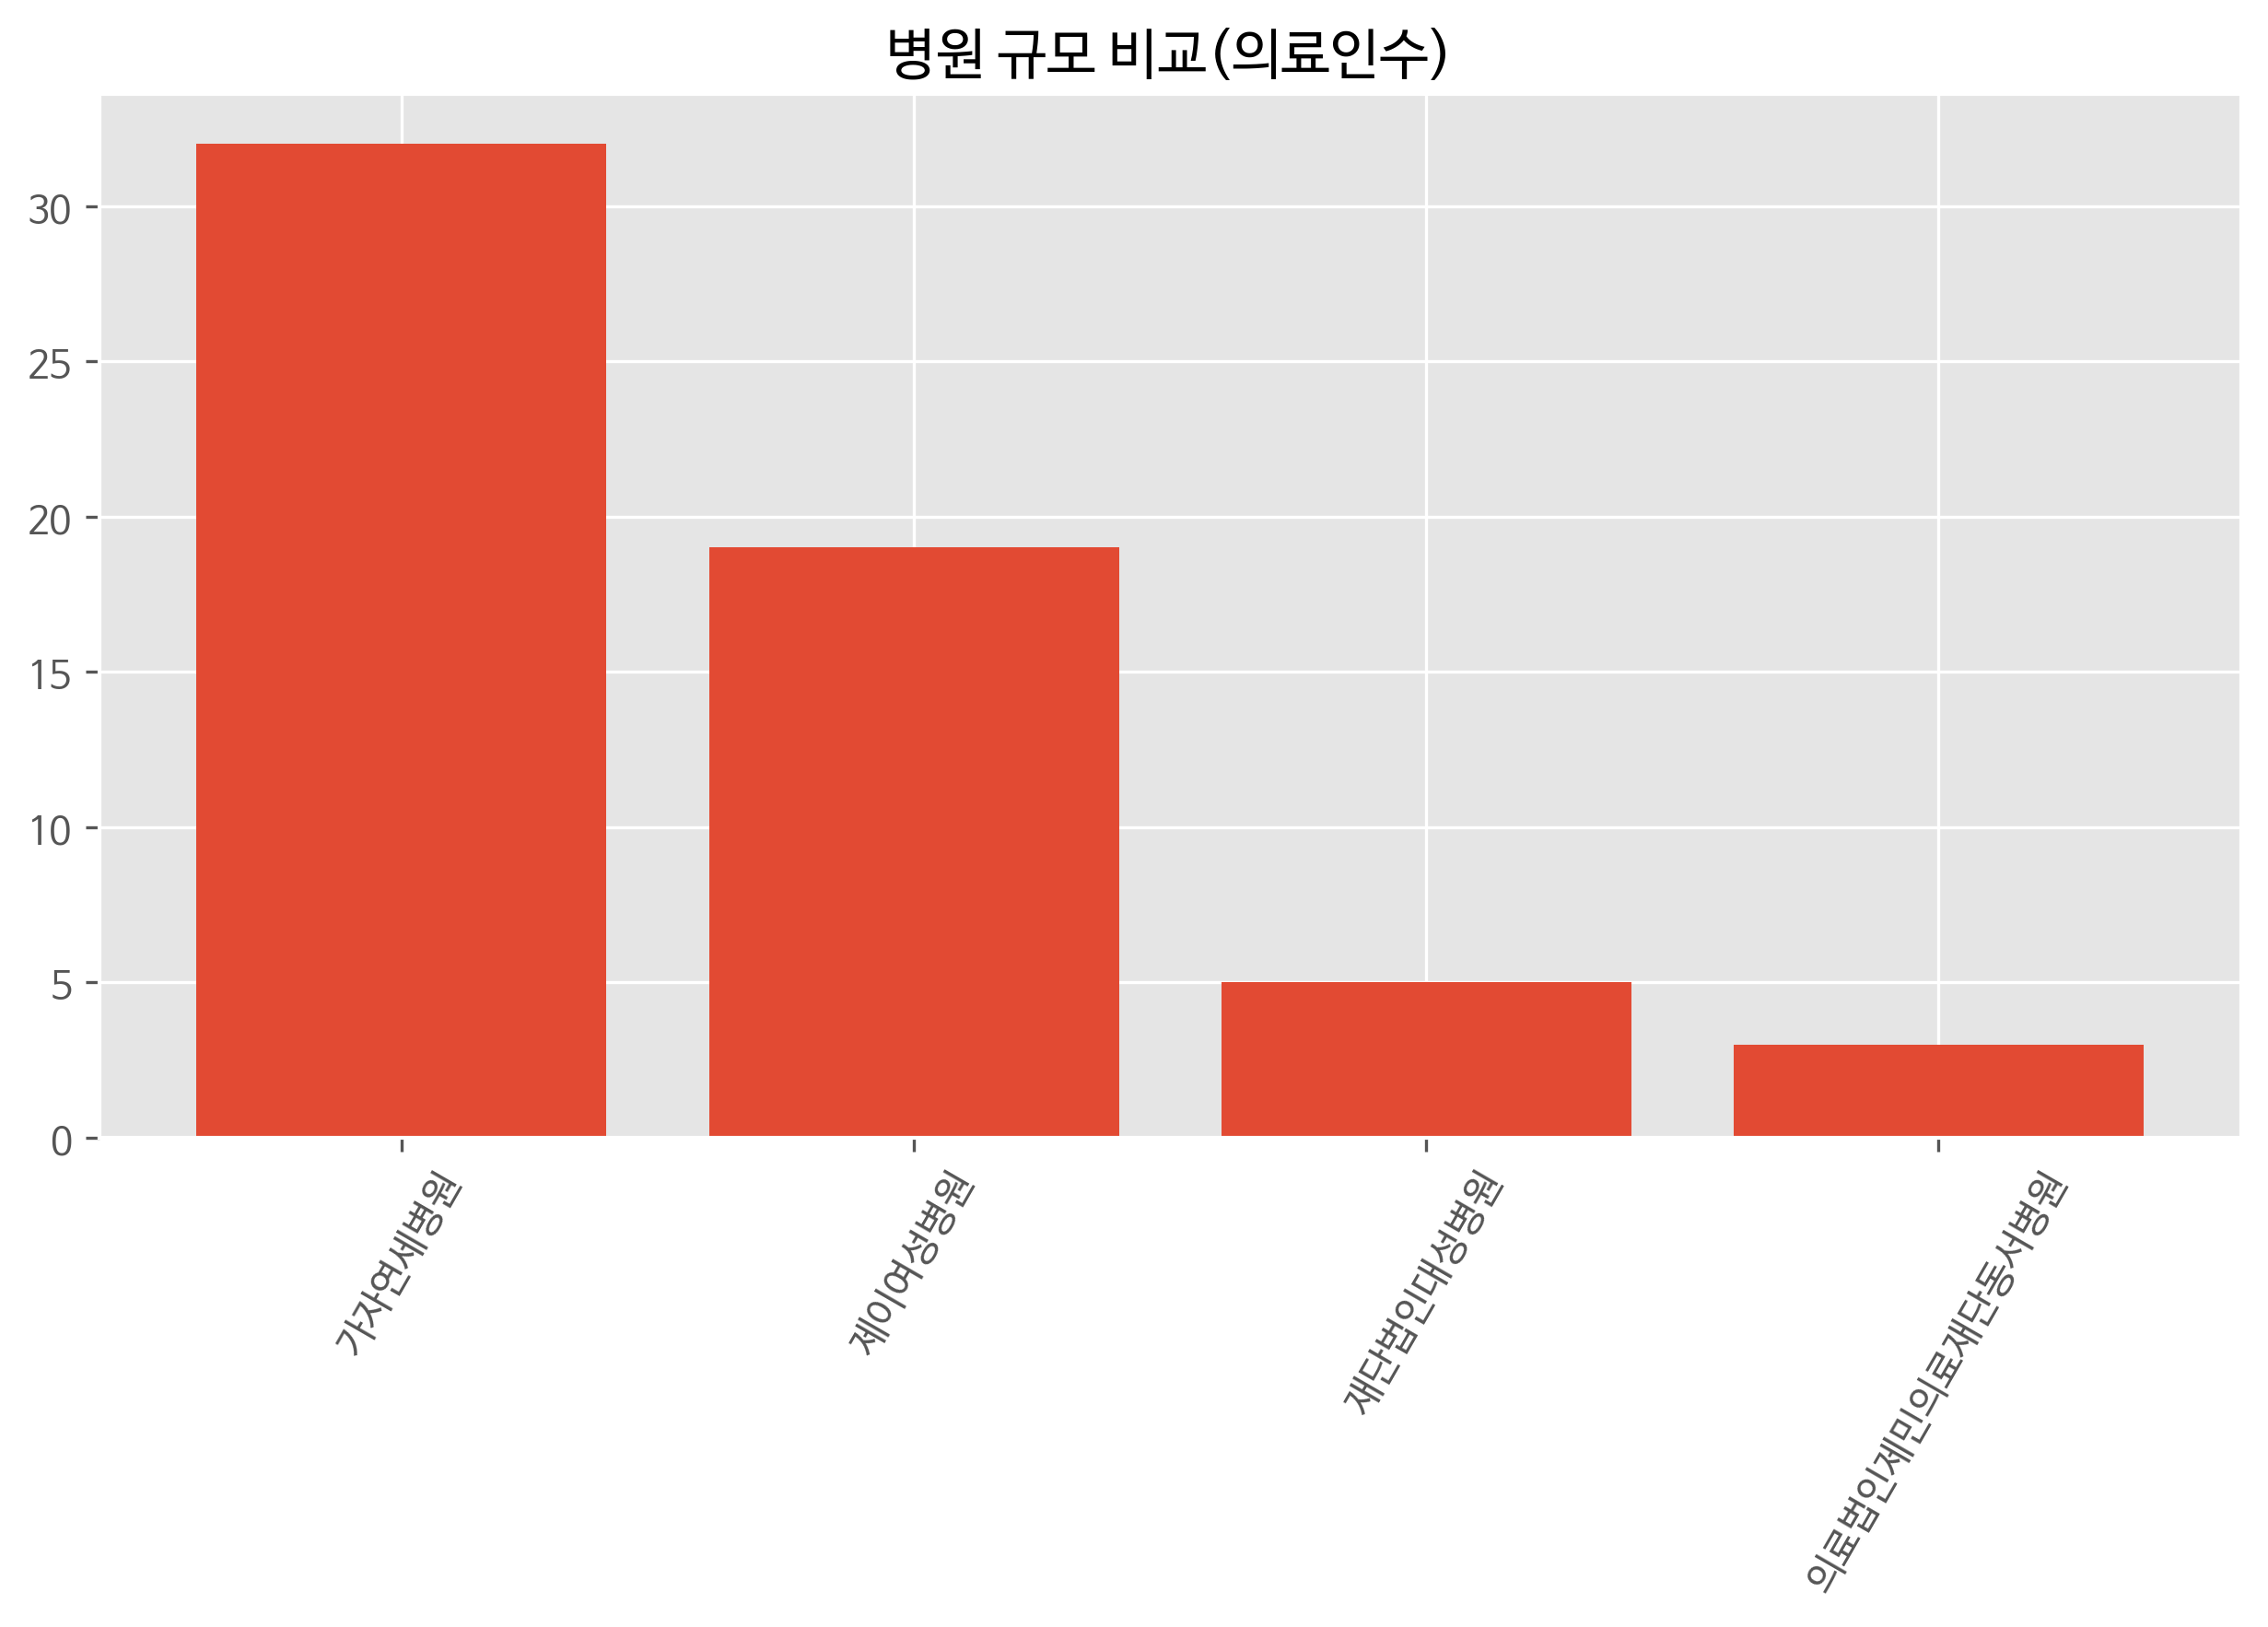


병원을 선택해서 비교하시겠습니까?
-비교하기: Y 입력
-그만두기: N 입력

	대답:Y

1. 병원 개별 정보 보기 
2. 두 병원 비교하기 
어떤 옵션을 실행할까요? 1

병원 이름을 입력하세요: 제이여성병원
     업태구분명                           도로명전체주소  영업상태명         소재지전화
번호                                                               
2737    병원  서울특별시 서대문구 통일로 442 (홍제동, 제이여성병원)  영업/정상  02-2153-7777

Y나 N으로 입력해주세요.
병원선택을 다시 실행할까요? Y

1. 병원 개별 정보 보기 
2. 두 병원 비교하기 
어떤 옵션을 실행할까요? 2

첫 번째 병원을 입력하세요: 제이여성병원
두 번째 병원을 입력하세요: 재단법인대성병원

1. 의료인수
2. 병상수
3. 총면적
4. 진료과목내용명
5. 도로명전체주소
    
ex 1,2,5
어떤 정보를 비교할까요? 1,3
      의료인수      총면적
번호                 
2703   5.0  1286.00
2737  19.0  2951.04
Y나 N으로 입력해주세요.
병원선택을 다시 실행할까요? N

다른 메뉴를 재실행할까요?
-재실행하기: Y 입력
-종료하기: N 입력
	대답:Y

메뉴 1 가까운 병원찾기
메뉴 2 병원 비교하기
메뉴 3 현황 체크하기 

숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 4
입력 오류!
숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 3

메뉴 3 현황 체크하기
각종 병원의 정보를 지역에 따라 시각화해볼 수 있는 메뉴입니다

1. 지역의 병원 종류
2. 입원실, 병상, 의료인 수
3. 병원 영업 현황 

병원 현황을 확인하고 싶은 지역을 입력하십시오.(ex. 서대문구): 서대문구
숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 1

🏥 서대문구의 병

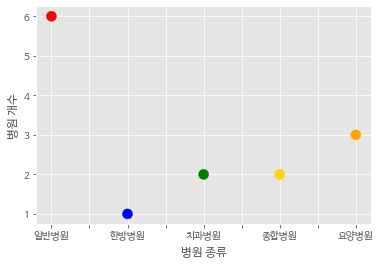

일반병원 6 개 / 한방병원 1 개 / 치과병원 2 개 / 종합병원 2 개 / 요양병원 3 개입니다.

다른 메뉴를 재실행할까요?
-재실행하기: Y 입력
-종료하기: N 입력
	대답:Y

메뉴 1 가까운 병원찾기
메뉴 2 병원 비교하기
메뉴 3 현황 체크하기 

숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 3

메뉴 3 현황 체크하기
각종 병원의 정보를 지역에 따라 시각화해볼 수 있는 메뉴입니다

1. 지역의 병원 종류
2. 입원실, 병상, 의료인 수
3. 병원 영업 현황 

병원 현황을 확인하고 싶은 지역을 입력하십시오.(ex. 서대문구): 서대문구
숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 2

🏥 서대문구의 입원실, 병상, 의료인 수 결과 🏥
전국에서 가장 많은 의료인 수, 병상 수, 입원실 수는 다음과 같습니다 
 의료인수    6204.0
입원실수     988.0
병상수     2715.0
dtype: float64
전국에서 가장 적은 의료인 수, 병상 수, 입원실 수는 다음과 같습니다 
 의료인수    1.0
입원실수    1.0
병상수     1.0
dtype: float64


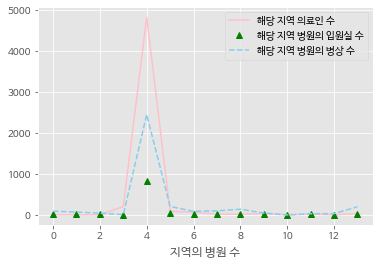


다른 메뉴를 재실행할까요?
-재실행하기: Y 입력
-종료하기: N 입력
	대답:Y

메뉴 1 가까운 병원찾기
메뉴 2 병원 비교하기
메뉴 3 현황 체크하기 

숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 3

메뉴 3 현황 체크하기
각종 병원의 정보를 지역에 따라 시각화해볼 수 있는 메뉴입니다

1. 지역의 병원 종류
2. 입원실, 병상, 의료인 수
3. 병원 영업 현황 

병원 현황을 확인하고 싶은 지역을 입력하십시오.(ex. 서대문구): 서대문구
숫자로 메뉴를 선택해주세요
(1/2/3을 입력해주세요)

	대답: 3

🏥 서대문구의 병원 영업 현황 결과 🏥


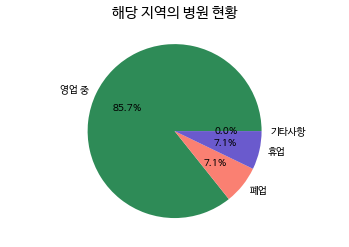

더 자세히 알아보고 싶은 항목을 선택하세요 
 1. 영업 중인 병원 
 2. 폐업한 병원 
 3. 휴업 중인 병원 
 4. 기타 병원

숫자로 메뉴를 선택해주세요
(1/2/3/4를 입력해주세요)

	대답: 1


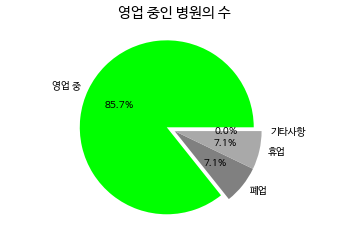

서대문구 지역의 영업 중인 병원의 수는 12 개 입니다.

다른 메뉴를 재실행할까요?
-재실행하기: Y 입력
-종료하기: N 입력
	대답:N

프로그램을 종료합니다.


In [ ]:
# 실행
print("파이썬데이터분석 아프지말아조\n나를 위한 병원 찾기 프로그램입니다 *^^*\n")    # 소개
print("시/도 정보가 필요합니다 \nex)서울특별시")
intro()
menu()
while True:
  answer=input("\n다른 메뉴를 재실행할까요?\n-재실행하기: Y 입력\n-종료하기: N 입력\n\t대답:")
  if answer=='Y':
    menu()
  elif answer=="N":
    print("\n프로그램을 종료합니다.")
    break
  else:
    print(R+"입력 오류!"+N)
    print("값을 올바르게 입력하세요")
    continue